In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable

from sklearn.preprocessing import normalize

from tqdm import tnrange, tqdm_notebook

In [2]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=200):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, 
                                               n_factors,
                                               sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, 
                                               n_factors,
                                               sparse=True)
        
    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)
    
    def user(self, user):
        return self.user_factors(user)
    
    def item(self, item):
        return self.item_factors(item)

In [3]:
original = pd.read_excel('online_retail.xlsx')
dat = pd.read_csv('rankings.csv')
cids = dat['CustomerID']
dat.drop('CustomerID', inplace=True, axis=1)

In [4]:
# instantiate model
n_users = dat.shape[0]
n_items = dat.shape[1]

model = MatrixFactorization(n_users, n_items, n_factors=400)

In [5]:
model.load_state_dict(torch.load('gpu_model.bin'))

In [6]:
#clustering items
item_factors = model.item(Variable(torch.LongTensor(range(n_items))))
item_similarities = torch.abs(torch.matmul(item_factors, item_factors.t()))

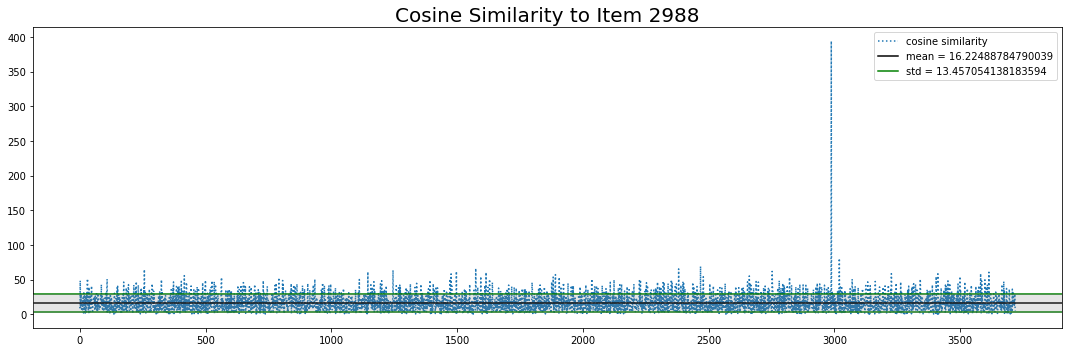

In [7]:
#verify similaritis match cosine_similarities from auto_mf_analysis
itemnumber = 2988
cosine_similarities = item_similarities[itemnumber,:].data.numpy()

plt.figure(figsize=(15,5))

plt.plot(cosine_similarities, label='cosine similarity', ls='dotted')

plt.axhline(cosine_similarities.mean(), c='k', label='mean = {}'.format(cosine_similarities.mean()))
plt.axhline(cosine_similarities.mean()+cosine_similarities.std(), c='g', label='std = {}'.format(cosine_similarities.std()))
plt.axhline(cosine_similarities.mean()-cosine_similarities.std(), c='g')
plt.axhspan(cosine_similarities.mean()+cosine_similarities.std(), cosine_similarities.mean()-cosine_similarities.std(), color='grey', alpha=.2, zorder=10)

plt.title('Cosine Similarity to Item {}'.format(itemnumber), fontsize=20)
plt.tight_layout()
plt.legend()

plt.show()


In [8]:
#clustering with 3 methods: naive, kmeans, and AgglomerativeClustering (ward)

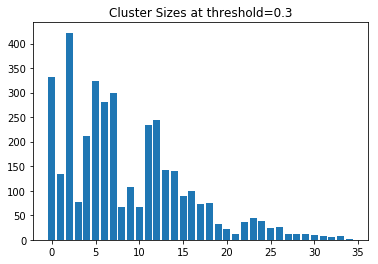

In [13]:
#First, home-rolled version
features = item_similarities.data.numpy().copy()
features = np.tril(features)
np.fill_diagonal(features, 0)
features = features / features.max()

threshold = 0.3
clusters = []
mx = features.max()
while mx > 0:
    key = np.where(features == mx)[0][0]
    thresh = threshold * mx
    others = np.where(features[key,:] > thresh)[0]
    group = [key] + others.tolist()
    clusters.append(group)
    for idx in group:
        features[idx,:] = 0
        features[:,idx] = 0
    mx = features.max()

sizes = list(map(len, clusters))
plt.bar(range(len(sizes)), sizes)
plt.title("Cluster Sizes at threshold={}".format(threshold))
plt.show()
num_clusters = len(clusters)

#build dict
nv_clusters = {}
for group_id, group in enumerate(clusters):
    for idx in group:
        nv_clusters[idx] = group_id

In [15]:
#Next, ward:
from sklearn.cluster import AgglomerativeClustering

features = item_similarities.data.numpy().copy()
np.fill_diagonal(features, 0)
np.fill_diagonal(features, features.max())
features = features / features.max()

ward = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=features)
ward.fit(features)

#build dict
ward_clusters = {}
for idx, group_id in enumerate(ward.labels_):
    ward_clusters[idx] = group_id

In [17]:
#Finally, k-means
from scipy.cluster.vq import kmeans, whiten

features = item_similarities.data.numpy().copy()
np.fill_diagonal(features,0)
np.fill_diagonal(features, features.max())
features = features / features.max()
features = whiten(features)

km = kmeans(features, num_clusters)

#build dict
km_clusters = {}
for idx, vals in enumerate(km[0].transpose()):
    km_clusters[idx] = np.argmax(vals)

In [34]:
#store everything in a dataframe (to export)
stock_codes = list(dat.columns)
item_table = pd.DataFrame(columns=['StockCode', 'Description', 'NaiveGrouping', 'WardGrouping', 'KMeanGrouping'])

for idx in nv_clusters.keys():
    code = stock_codes[idx]
    try:
        code = int(code)
    except:
        pass
    
    try:
        desc = original[original['StockCode'] == code].iloc[0]['Description']

        item_table = item_table.append({
            'StockCode':code,
            'Description':desc,
            'NaiveGrouping':nv_clusters[idx],
            'WardGrouping':ward_clusters[idx],
            'KMeanGrouping':km_clusters[idx]
            }, ignore_index=True)
    except:
        print("Bad description?", code)

item_table

Bad description? Country_Israel nan
Bad description? Country_Austria POSTAGE
Bad description? Country_Belgium POSTAGE
Bad description? Country_Channel Islands POSTAGE
Bad description? Country_European Community POSTAGE
Bad description? Country_France POSTAGE
Bad description? Country_Singapore BLUE/GREEN SHELL NECKLACE W PENDANT
Bad description? Country_Czech Republic LETTER "K" BLING KEY RING
Bad description? Country_RSA LETTER "K" BLING KEY RING
Bad description? Country_Spain JASMINE VOTIVE CANDLE
Bad description? Country_Brazil LETTER "O" BLING KEY RING
Bad description? Country_Canada LETTER "O" BLING KEY RING
Bad description? Country_Greece LETTER "O" BLING KEY RING
Bad description? Country_Portugal LETTER "O" BLING KEY RING
Bad description? Country_Bahrain GYMKHANNA TREASURE BOOK BOX
Bad description? Country_Italy BLACK SWEETHEART BRACELET
Bad description? Country_EIRE LETTER "F" BLING KEY RING
Bad description? Country_Unspecified LETTER "F" BLING KEY RING
Bad description? Country_

,StockCode,Description,NaiveGrouping,WardGrouping,KMeanGrouping
0,46000M,POLYESTER FILLER PAD 45x45cm,0,1,3
1,10080,GROOVY CACTUS INFLATABLE,0,3,14
2,10120,DOGGY RUBBER,0,27,22
3,15034,PAPER POCKET TRAVELING FAN,0,21,10
4,16014,SMALL CHINESE STYLE SCISSOR,0,25,14
5,16045,POPART WOODEN PENCILS ASST,0,13,30
6,16046,TEATIME PEN CASE & PENS,0,2,27
7,20661,BLUE POLKADOT PURSE,0,13,18
8,20701,PINK CAT FLORAL CUSHION COVER,0,29,20
9,20705,MRS ROBOT SOFT TOY,0,26,14


In [35]:
#save
item_table.to_csv("item_table.csv", index=False)

In [37]:
#now to repeate for users
factors = model.user(Variable(torch.LongTensor(range(n_users))))
similarities = torch.abs(torch.matmul(factors, factors.t()))

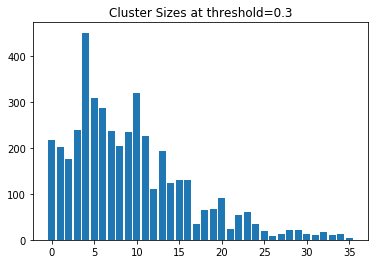

In [38]:
#naive
features = similarities.data.numpy().copy()
features = np.tril(features)
np.fill_diagonal(features, 0)
features = features / features.max()

threshold = 0.3
clusters = []
mx = features.max()
while mx > 0:
    key = np.where(features == mx)[0][0]
    thresh = threshold * mx
    others = np.where(features[key,:] > thresh)[0]
    group = [key] + others.tolist()
    clusters.append(group)
    for idx in group:
        features[idx,:] = 0
        features[:,idx] = 0
    mx = features.max()

sizes = list(map(len, clusters))
plt.bar(range(len(sizes)), sizes)
plt.title("Cluster Sizes at threshold={}".format(threshold))
plt.show()
num_clusters = len(clusters)

#build dict
nv_clusters = {}
for group_id, group in enumerate(clusters):
    for idx in group:
        nv_clusters[idx] = group_id

In [40]:
#ward
features = similarities.data.numpy().copy()
np.fill_diagonal(features, 0)
np.fill_diagonal(features, features.max())
features = features / features.max()

ward = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=features)
ward.fit(features)

#build dict
ward_clusters = {}
for idx, group_id in enumerate(ward.labels_):
    ward_clusters[idx] = group_id

In [41]:
#kmeans
features = similarities.data.numpy().copy()
np.fill_diagonal(features,0)
np.fill_diagonal(features, features.max())
features = features / features.max()
features = whiten(features)

km = kmeans(features, num_clusters)

#build dict
km_clusters = {}
for idx, vals in enumerate(km[0].transpose()):
    km_clusters[idx] = np.argmax(vals)

In [42]:
#build another table
user_table = pd.DataFrame(columns=['CustomerID', 'NaiveGrouping', 'WardGrouping', 'KMeanGrouping'])

for idx in nv_clusters.keys():
    
    user_table = user_table.append({
        'CustomerID': cids[idx],
        'NaiveGrouping':nv_clusters[idx],
        'WardGrouping':ward_clusters[idx],
        'KMeanGrouping':km_clusters[idx]
        }, ignore_index=True)

user_table

,CustomerID,NaiveGrouping,WardGrouping,KMeanGrouping
0,15796.0,0.0,6.0,8.0
1,12357.0,0.0,15.0,9.0
2,12365.0,0.0,7.0,19.0
3,12375.0,0.0,22.0,21.0
4,12393.0,0.0,10.0,10.0
5,12403.0,0.0,16.0,26.0
6,12409.0,0.0,28.0,25.0
7,12413.0,0.0,31.0,15.0
8,12414.0,0.0,10.0,32.0
9,12428.0,0.0,31.0,29.0


In [43]:
user_table.to_csv("user_table.csv", index=False)